In [4]:
# To display animated movies in the same way as with in-line python:
%matplotlib notebook 
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
import math

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import Accordion, IntSlider, FloatSlider, HTMLMath, Dropdown, Box, HBox, VBox, Layout, Play, jslink
from IPython.display import display, HTML, Video, Audio, clear_output

In [5]:
# Set background color
plt.style.use('dark_background') # Global background color of the figure
plt.ioff() # Prevents figures from displaying unless explicitly asked for

# Define some custom colors we might use
nice_blue0 = [ 0.74800463,  0.82674357,  0.9015917,   1.  ]
nice_blue = [ 0.54901963,  0.58559018,  0.77517879,  1. ]
nice_blue1 = np.array([ 135,  170,  222,  255. ])
nice_blue1/=255
gold = "#ffff33"
gold1 = "#ffdd55ff"
my_color = gold1
textcolor=nice_blue
facecolor="black"

In [6]:
# Define dimensions and set up initial drawing

nb_balls = 100 # We should put at least as many balls as number of rows
nb_rows = 5

count_balls = np.zeros(nb_rows,dtype=int)

In [7]:
def get_dist_vect(p_, q_): # Calculates distance between 2 points
  # Vectorized version
  return np.sqrt(np.sum((p_-q_)**2,axis=2))

def create_nodes(nb_rows):
    nodes = np.array([[0,0]])
    for i in range(-1,-nb_rows,-1):
        for j in range(i,-i+1,2):
            nodes = np.append(nodes,[[j,i]],axis=0)
    return nodes

nodes = create_nodes(nb_rows)
      
N = len(nodes) # Number of points (actually should be nb_rows*(nb_rows+1)/2)

# The following is overcomplicated for the task it aims at achieving, as I simply copy/pasted a slice of code I had done for solving a more complex problem of connecting nodes based on a given threshold.
# It is not optimized (the algorithm could be made linear), but it does not matter for this problem.
# In the end, it simply builds the connections between nodes. Here the coordinates of the nodes are (0,0),(-1,-1),(-1,1),(-2,-2),(0,-2),(2,-2), etc. so connected nodes are separated by a length of sqrt(2).
# Instead, since the pattern is known beforehand, one could directly draw the lines, going from one node to the next. Anyways... :)

# Calculate all distances between all points and store them into a matrix dist_mat, the indices of which will correspond to the points' ids
i_, j_ = np.ogrid[:N,:N]
dist_mat = get_dist_vect(nodes[i_],nodes[j_])

# Create list of links which will contain all the links between points.
links_list = [[i] for i in range(N*(N+1)//2)]

# Loop over matrix of distances and check whether or not its elements are below the threshold
threshold = 1.5 # in truth should be sqrt(2)
for i_,row in enumerate(dist_mat):
    for j_,col in enumerate(row[i_:]):
        if (col < threshold and col > 0):
            links_list[i_].append(i_+j_) # Add id of the connected point...
            links_list[i_+j_].append(i_) # ...and its symmetric counterpart

segments_x = []
segments_y = []
for i,neighbours in enumerate(links_list):
    for node in neighbours[1:]:
        segments_x = np.append(segments_x,[nodes[i,0],nodes[node,0],None])
        segments_y = np.append(segments_y,[nodes[i,1],nodes[node,1],None])


In [8]:
# Set up plot

fig = plt.figure(); # initialise la figure
ax = plt.axes(xlim=(-nb_rows, nb_rows), ylim=(-1.7*nb_rows-1,1)); # That will leave about 1*nb_rows for the bean machine, and 0.7*nb_rows for the histogram
ax.set_aspect('equal') # Use same scale for x and y, in order not to distort the grid (i.e., have a square grid: it's prettier, I think!)
plt.axis('off') # Hide axis
# Hide tick labels
#ax.set_yticklabels([])
#ax.set_xticklabels([])

# Plot nodes
scatt_nodes = plt.scatter(nodes[:,0],nodes[:,1],s=30,edgecolor=nice_blue1,color=nice_blue1);
# Plot node paths
plt.plot(segments_x,segments_y);

# Define initial ball position at coordinates (0,0). Note: could be done instead in the 'init' function later on...
pos_balls = np.array([[0.,0.]])

# Place current balls on graph (at this point there is just 1 ball...)
balls, = ax.plot(pos_balls[:,0], pos_balls[:,1], 'o', color=my_color) 

# Display as a histogram (bar plot) how many times the nodes of the last row have been visited
# Standard bar plots cannot be updated with matplotlib, so I simply made a bar plot 'by hand' with the usual plot function
# 'None' is for plotting segments instead of a continuous line
indexes = [[i,i,None] for i in range(-nb_rows+1,nb_rows+1,2)]
values = [[i,0,None] for i in count_balls]
indexes = np.array(indexes).flatten()
values = np.array(values).flatten()
bars, = ax.plot(indexes,values,lw=3,color=my_color)

# Display number of times the nodes of the last row have been visited (note to self: we could display numbers for all nodes as well...)
# This is actually strictly equivalent to the histogram defined above, but hey, I like seeing numbers as well!
annotations = []
for i_ in range(-nb_rows+1,nb_rows+1,2):
    annotations.append(plt.annotate("0",(i_-0.15,-nb_rows),color=nice_blue0))

In [9]:
# Function to define when blit=True. Create background of the animation that will be present on each image
#def init():
#    bidule = 0 # dummmy variable
#    #balls.set_data([],[])
#    #return balls,

# Define animation function that updates the plot
def animate_curve(i): 
    
    global pos_balls
    global count_balls
    global nb_rows
    global nb_balls
    global move
    global dr
  
    if (pos_balls[0,0]%1 == 0.): # When the (x) position of a ball is an integer, it means it has reached a node and a random move has to be made

    # Add new ball to the game unless we have reached the total amount of balls specified (the last ball still has to go through the nb_rows levels)
        if (i>1 and sum(count_balls) <= nb_balls - nb_rows+1):
            pos_balls = np.append(pos_balls,[[0,0]],axis=0)

        for j,el in enumerate(pos_balls):
          # If a ball reaches the last row
          if int(el[1]) == -nb_rows+1:
            # Do mapping between x coordinate of the ball and the actual index of the last node hit by the ball (= tube in the original Galton experiment)
            # x:     -4 -2  0  2  4
            # index:  0  1  2  3  4           (for nb_rows=5)
            # 0=-4+(4-(-4))/2 ;  1=-2+(4-(-2))/2 ; ...
            index = int(el[0])+int(nb_rows-1-el[0])//2
            # Increment counter
            count_balls[int(el[0])+int(nb_rows-1-el[0])//2] += 1
            # Remove ball from the game
            pos_balls = np.delete(pos_balls,j,0)

            # Getting data to update histogram 
            # Get how many times the node has been visited...
            count = int(annotations[index].get_text())
            # ... and increment it by 1.
            annotations[index].set_text(count+1)

            new_ydata = np.array([])
            # We normalize by the highest peak
            norm_factor = max(count_balls)
            # We want the histogram to be displayed downwards, below the bean machine, so we start at -nb_rows-1. 
            # Then the prefactor is just to make the histogram fill the empty space for any input of nb_rows. About 2/3 (in height) of the plot is filled by the bean machine.
            for k in count_balls:
                new_ydata = np.append(new_ydata,[-nb_rows-1,-nb_rows-1-0.5*nb_rows*k/max(count_balls),None])
            bars.set_ydata(new_ydata)

        # Randomly pick a move for each ball. -1 is left, +1 is right
        #move = np.random.randint(2,size=len(pos_balls))
        move = np.random.choice([-1,1], size=len(pos_balls), p=[0.50, 0.50])

    # Update x and y coordinates
    pos_balls[:,0] += move*dr
    pos_balls[:,1] -= dr # The balls go down
    pos_balls = np.round(pos_balls,1) # Round to 1st decimal to avoid numbers not talling up exactly to an integer (0.1+0.1+... ten times is != 1 in base 2, which is problematic for matching a boolean condition)

    # Update balls coordinates 
    balls.set_xdata(pos_balls[:,0])
    balls.set_ydata(pos_balls[:,1])
    
#     display(fig)

    return balls,# annotations, bars,

dr = 0.1 # "time step". 0.1 should be enough for a smooth animation even at low speed.
n_frames = int((nb_balls + nb_rows-1)/dr+1)-1 # It seems that when the init function is used, it uses 1 more frame...
#ani_curve = animation.FuncAnimation(fig, animate_curve, init_func=init, frames=1000, blit=True, interval=10, repeat=False)

<IPython.core.display.Javascript object>


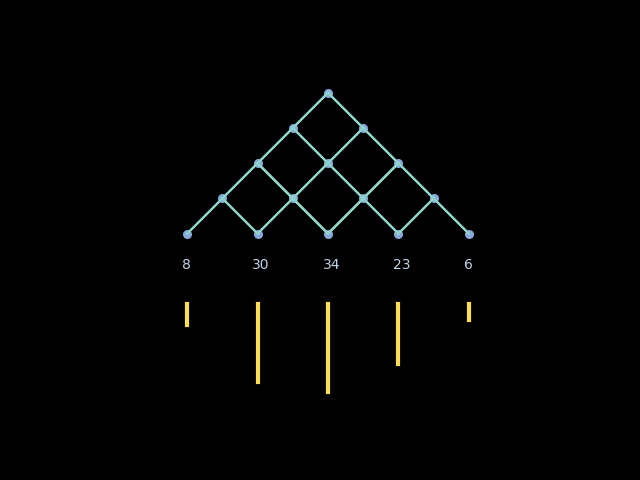

In [10]:
ani_curve = animation.FuncAnimation(fig, animate_curve, frames=n_frames, interval=20,blit=True, repeat=False)

# HTML(ani_curve.to_html5_video()) # Calculates all frames, and then displays the video
# HTML(ani_curve.to_jshtml()) # Calculates all frames, and then displays video as an interactive widget
# Show animation
# plt.show()
display(fig)

In [8]:
step_widget = widgets.IntSlider(min=0, max=1000, step=1, value=0, description = "$\\theta$", continuous_update=True)
# type_widget = Dropdown(options=(
#         ("Random","random"),
#         ("Consecutive","consecutive"),
#         ("Manual","manual"),    
#     ), 
#     description = "Selection type", continuous_update=False, layout=Layout(width='250px'))
# button_clear = widgets.Button(description="Clear selection!")
play_button = Play(min=0, max=100, step=1, interval=20)
jslink((play_button, 'value'), (step_widget, 'value'))

In [9]:
# Define function to be called when play button is pressed
def on_change_balls(change):
    _ = animate_curve(i=step_widget.value)
    
# angle_widget.observe(on_change0, names='value', type='change')
step_widget.observe(on_change_balls, names='value', type='change')

Box(children=(HBox(children=(Play(value=0, interval=20), IntSlider(value=0, description='$\\theta$', max=1000)…

<IPython.core.display.Javascript object>


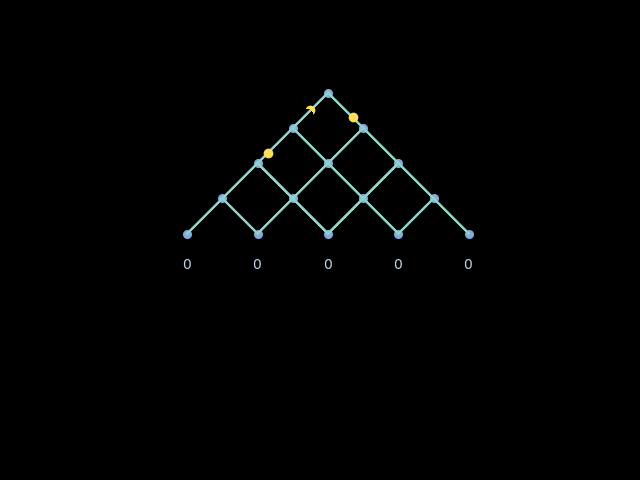

In [10]:
display(Box([
        HBox([play_button,step_widget], layout=Layout(justify_content='center',width='905px'))],
        layout=Layout(width='100%', flex_flow='row wrap', display='flex')))
display(fig)